In [1]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
from torch import nn
import matplotlib.pyplot as plt
# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-ade-512-512")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-512-512")
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-640-1280")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-640-1280")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image=Image.open('2.jpg')
inputs = feature_extractor(images=image, return_tensors="pt")
model.to('cuda')
inputs.to('cuda')
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height, width)
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

C:\Users\mmkha\anaconda3\envs\torch\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\mmkha\anaconda3\envs\torch\Lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


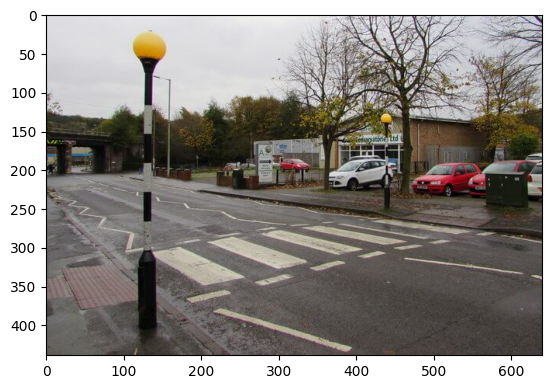

In [2]:
import matplotlib.pyplot as plt
plt.imshow(image)


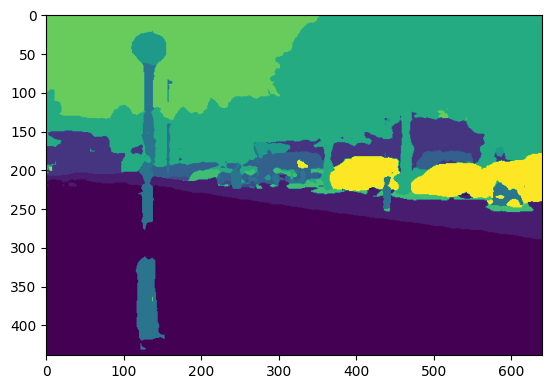

In [3]:
plt.imshow(pred_seg.cpu())


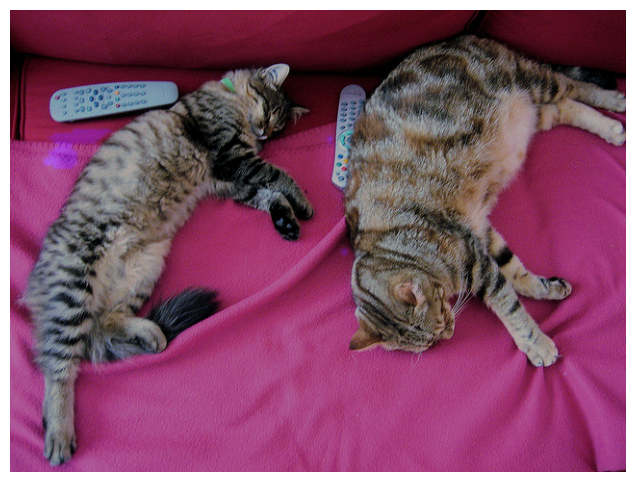

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from torchvision import transforms

# Load and preprocess the image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
inputs = feature_extractor(images=image, return_tensors="pt")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Run inference
outputs = model(**inputs)
logits = outputs.logits
probs = logits.softmax(dim=1)
probs_np = probs[0].cpu().detach().numpy()

# Choose a threshold
threshold = 0.5

# Create a color map for visualization
color_map = np.array([
    [0, 0, 0],       # Background
    [255, 0, 0],     # Class 1
    [0, 255, 0],     # Class 2
    [0, 0, 255]      # Class 3 (example)
])

# Initialize an empty mask
segmentation_mask = np.zeros((probs_np.shape[1], probs_np.shape[2], 3), dtype=np.uint8)

# Overlay color-coded masks on the original image
for class_idx in range(1, color_map.shape[0]):
    class_mask = (probs_np[class_idx] > threshold).astype(np.uint8)
    for i in range(3):
        segmentation_mask[:, :, i][class_mask == 1] = color_map[class_idx, i]

# Resize the mask to match the original image size
segmentation_mask_resized = transforms.Resize(image.size[::-1])(Image.fromarray(segmentation_mask))

# Combine original image and resized segmentation mask
visualization = Image.blend(image, segmentation_mask_resized, alpha=0.3)

# Display the visualization
plt.figure(figsize=(12, 6))
plt.imshow(visualization)
plt.axis('off')
plt.show()

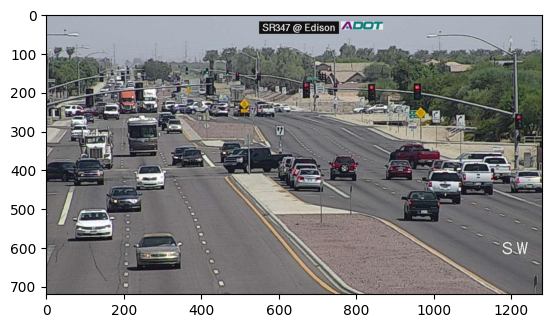

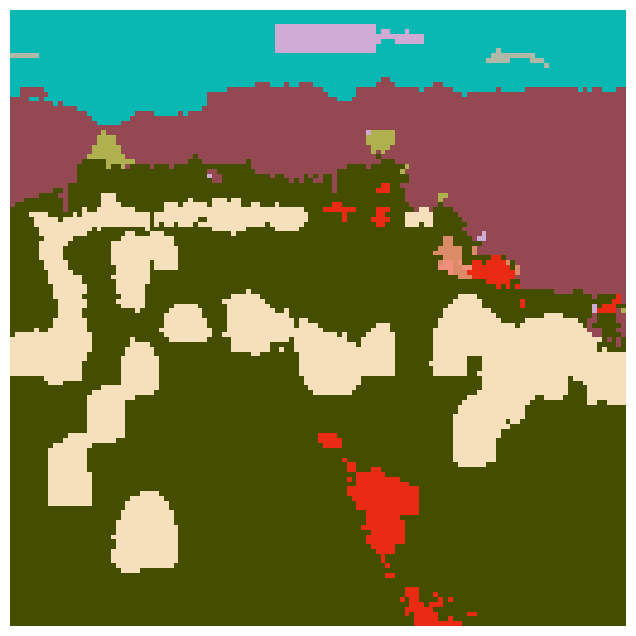

In [5]:
import requests
import numpy as np
from PIL import Image
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import cv2
import matplotlib.pyplot as plt

# Load and preprocess the image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image=Image.open('1.jpg')

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
inputs = feature_extractor(images=image, return_tensors="pt")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Run inference
outputs = model(**inputs)
segmentation_results = outputs.logits.argmax(1).squeeze().cpu().numpy()

# Define color map for classes
color_map = np.random.randint(0, 255, size=(np.max(segmentation_results) + 1, 3), dtype=np.uint8)

# Apply color map to segmentation results
colored_mask = color_map[segmentation_results]

plt.imshow(image)
# Display the segmentation results using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(colored_mask)
plt.axis('off')
plt.show()


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Predicted Class: trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi


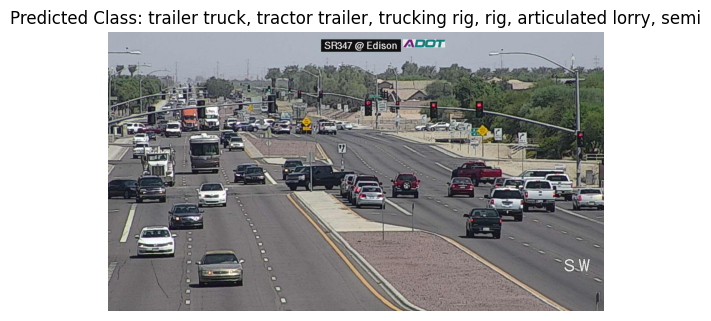

In [6]:
from transformers import AutoImageProcessor, SegformerForImageClassification
import torch
import requests
from PIL import Image
import matplotlib.pyplot as plt

# Load image
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

image = Image.open('1.jpg')
# Load image processor and model
image_processor = AutoImageProcessor.from_pretrained("nvidia/mit-b0")
model = SegformerForImageClassification.from_pretrained("nvidia/mit-b0")

# Preprocess image
inputs = image_processor(images=image, return_tensors="pt")

# Run inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get predicted label
predicted_label = logits.argmax(-1).item()
predicted_class = model.config.id2label[predicted_label]
print("Predicted Class:", predicted_class)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class}")
plt.show()
